In [1]:
%matplotlib notebook
# Our stuff:
import casclik as cc
import casadi as cs
from urdf2casadi import converter, numpy_geom, casadi_geom

# Plotting
from matplotlib import pyplot as plt

import common_plots

In [2]:
# Let's convert some casadi_geom expressions into functions so they work with MX variables
quat1 = cs.SX.sym("quat1",4) # quaternions
quat2 = cs.SX.sym("quat2",4)
quaternion_product = cs.Function("quatprod",[quat1,quat2],[casadi_geom.quaternion_product(quat1,quat2)])
quaternion_conj = cs.Function("quatconj", [quat1], [casadi_geom.quaternion_conj(quat1)])
hamilton_operator_plus = cs.Function(
    "hamilton_operator_plus",
    [quat1],
    [cs.vertcat(cs.horzcat(quat1[3], -quat1[2], quat1[1], quat1[0]),
                cs.horzcat(quat1[2], quat1[3], -quat1[0], quat1[1]),
                cs.horzcat(-quat1[1], quat1[0], quat1[3], quat1[2]),
                cs.horzcat(-quat1[0], -quat1[1], -quat1[2], quat1[3]))])
hamilton_operator_minus = cs.Function(
    "hamilton_operator_minus",
    [quat1],
    [cs.vertcat(cs.horzcat(quat1[3], quat1[2], -quat1[1], quat1[0]),
               cs.horzcat(-quat1[2], quat1[3], quat1[0], quat1[1]),
               cs.horzcat(quat1[1], -quat1[0], quat1[3], quat1[2]),
               cs.horzcat(-quat1[0], -quat1[1], -quat1[2], quat1[0]))])

quat1 = cs.SX.sym("quat1",8) # Dual quaternions
quat2 = cs.SX.sym("quat2",8)
dual_quaternion_product = cs.Function("dualquatprod", 
                                      [quat1,quat2], 
                                      [casadi_geom.dual_quaternion_product(quat1,quat2)])
dual_quaternion_conj = cs.Function("dualquatconj", 
                                   [quat1], 
                                   [casadi_geom.dual_quaternion_conj(quat1)])
dual_quaternion_dualnorm = cs.Function("dualquatdualnorm",
                                       [quat1], 
                                       [casadi_geom.dual_quaternion_norm2(quat1)[0],casadi_geom.dual_quaternion_norm2(quat1)[1]])
dual_quaternion_inv = cs.Function("dualquatinv", 
                                  [quat1], 
                                  [casadi_geom.dual_quaternion_inv(quat1)])
dual_quaternion_to_transformation_matrix = cs.Function("dualquat2transfmat",
                                                       [quat1],
                                                       [casadi_geom.dual_quaternion_to_transformation_matrix(quat1)])
dual_quaternion_to_pos = cs.Function("dualquat2pos",
                                    [quat1],
                                    [casadi_geom.dual_quaternion_to_pos(quat1)])

xyz=cs.SX.sym("xyz",3)
rpy=cs.SX.sym("rpy",3)
dual_quaternion_rpy = cs.Function("dualquatrpy",
                                  [rpy],
                                 [casadi_geom.dual_quaternion_rpy(rpy)])
dual_quaternion_xyz = cs.Function("dualquatxyz",
                                 [xyz],
                                 [casadi_geom.dual_quaternion_translation(xyz)])
axis = cs.SX.sym("axis",3)
ang = cs.SX.sym("ang")
dual_quaternion_axis_translation = cs.Function("dualquataxistransl",
                                              [axis, ang],
                                              [casadi_geom.dual_quaternion_axis_translation(axis,ang)])
dual_quaternion_axis_rotation = cs.Function("dualquataxisrot",
                                           [axis, ang],
                                           [casadi_geom.dual_quaternion_axis_rotation(axis,ang)])

# UR5 Example
Note: This example requires access to urdf2casadi, a python module for converting urdf files and kinematic chains to casadi functions describing their forward kinematics.

ALSO: If this is your first UR5 example, please go through the ur5_transformation_matrix_comparison_of_controllers first.

First, let's define the basic symbols:

In [3]:
t = cs.MX.sym("t")
q = cs.MX.sym("q",6) # six actuated joints
dq = cs.MX.sym("dq",6)
max_speed = cs.np.pi/5 # rad/s
UR5_home = [0.0, -cs.np.pi/2, 0.0, -cs.np.pi/2, 0.0, 0.0]

## Get dual quaternion of forward kinematics
The converter creates a kinematic chain from a specific root link to an end link. Running `check_urdf` on the file, we find that the UR5 contains the links:
```
root Link: world has 1 child(ren)
    child(1):  base_link
        child(1):  base
        child(2):  shoulder_link
            child(1):  upper_arm_link
                child(1):  forearm_link
                    child(1):  wrist_1_link
                        child(1):  wrist_2_link
                            child(1):  wrist_3_link
                                child(1):  ee_link
                                child(2):  tool0
```
Dual quaternions are more succinct representations of the transformation, but require that we convert it back and forth to transformation matrices to have something that is human readable.
Let's set up the forward kinematics:

In [4]:
urdf_path = "./urdf/ur5.urdf"
links = ["world", 
         "base_link", 
         "base", 
         "shoulder_link", 
         "upper_arm_link", 
         "forearm_link", 
         "wrist_1_link", 
         "wrist_2_link", 
         "wrist_3_link", 
         "tool0"]
fk_dict = converter.from_file(root="base_link", tip="tool0", filename=urdf_path)

In [5]:
fk_dict["joint_names"]

['shoulder_pan_joint',
 'shoulder_lift_joint',
 'elbow_joint',
 'wrist_1_joint',
 'wrist_2_joint',
 'wrist_3_joint']

In [6]:
# Setup the function for the dual quaternion of the forward kinematics:
Q_fk = fk_dict["dual_quaternion_fk"]

# Test transformation matrix:
Q0 = Q_fk(UR5_home)
T0 = numpy_geom.dual_quaternion_to_transformation_matrix(Q0.toarray())
print("Dual Quaternion: "+str(Q0))
print("Distance to UR5_pome pos: "+str(cs.norm_2(T0[:3,3])))

Dual Quaternion: [-0.707107, -3.46237e-12, -3.46237e-12, 0.707107, -3.40946e-13, -0.28624, 0.421616, 3.21923e-13]
Distance to UR5_pome pos: 1.0192


In [7]:
#For logging purposes we also prepare T_fk
T_fk = fk_dict["T_fk"]

In [8]:
# Check the joint limits from the URDF:
q_max = cs.np.array(fk_dict["upper"])
q_min = cs.np.array(fk_dict["lower"])
print("q_min ",str(q_min))
print("q_max ",str(q_max))

('q_min ', '[-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]')
('q_max ', '[ 6.28318531  6.28318531  3.14159265  6.28318531  6.28318531  6.28318531]')


In [9]:
# Define the basic system limits
# Uphold the joint constraints
joint_limits_cnstr = cc.SetConstraint(
    label="Joint_Limits",
    expression = q,
    set_min = q_min,
    set_max = q_max)

# Listify the joint limits constraints for pseudoinverse, starting with the lowest
joint_limits_cnstr_list = []
for i in range(q.size()[0]):
    joint_limits_cnstr_list.append(
    cc.SetConstraint(label="limit_q_"+str(i),
                     expression=q[i],
                     set_min = q_min[i],
                     set_max = q_max[i],
                    priority = i))

# Let's have some speed limit
joint_speed_limits_cnstr = cc.VelocitySetConstraint(
    label="Joint_speed_limits",
    expression = q,
    set_min = -cs.vertcat([max_speed]*q.size()[0]),
    set_max = cs.vertcat([max_speed]*q.size()[0]))

## Move to point skill
In dual quaternions, moving to a point equates to ensuring that the quaternion denoting displacement matches the desired Cartesian position. Let's recall from theory that a dual quaternion $\check{\mathbf{Q}} = (\mathbf{Q}_{r}, \mathbf{Q}_\Delta)$, aka composed of a rotation quaternion and a "displacement" quaternion. The displacement quaternions are constructed such that:
$$
\mathbf{Q}_\Delta = \frac{1}{2}\grave{\mathbf{p}}\otimes \mathbf{Q}_{r}
$$
where $\otimes$ is the quaternion product, and $\mathbf{p}$ is the translation represented in the quaternion, the accent above denotes that it is 4D with the 4th element being 1. Then rearranging we arrive at:
$$
\grave{\mathbf{p}} = 2\mathbf{Q}_{\Delta} \otimes \mathbf{Q}_r^*
$$
with $^*$ denoting the conjugate.

Then it's easy to think of a few simple ways to move to a point:

1. Minimize the Cartesian distance error $$2\mathbf{Q}_{\Delta,fk}\otimes\mathbf{Q}_r^*[:3] - \mathbf{p}_{des}$$
2. Minimize the quaternion distance expression $$1-\mathbf{Q}_{\Delta,fk}\cdot(\frac{1}{2}\grave{\mathbf{p}}_{des}\otimes\mathbf{Q}_r)$$
3. Minimize the difference between the quaternions $$ \mathbf{Q}_{\Delta,fk} - \frac{1}{2}\grave{\mathbf{p}}_{des}\otimes\mathbf{Q}_r$$

In this example we will investigate the first and the third approach. Number 2 is a good distance metric one can use on quaternions, but in testing it didn't seem to work. This could be because of numerical issues, or because of implementation issues. If you'd like to test it for yourself, uncomment the line called proper distance metric and comment out the "improper" distance metric.

In [10]:
# Desired point
p_des = cs.np.array([0.5,
                     0.5,
                     0.5])
# Desired point
p_des_a = cs.np.hstack([p_des, 0.0])
Q_r = Q_fk(q)[:4]
Q_d = Q_fk(q)[4:8]
cart_dist = 2*quaternion_product(Q_d, quaternion_conj(Q_r))[:3]
#quat_dist = 1 - cs.dot(Q_d, 0.5*quaternion_product(p_des_a, Q_r)) # Proper distance metric
quat_dist = Q_d[:3] - 0.5*quaternion_product(p_des_a,Q_r)[:3] # "Improper" distance metric on quaternions, but 
cart_dist_cnstr = cc.EqualityConstraint(
    label="cart_dist",
    expression=cart_dist,
    gain = 1.0,
    priority = 300,
    constraint_type="soft"
)
cart_dist_cnstr.eval = cs.Function("cart_dist", [t,q], [cs.norm_2(cart_dist)])

quat_dist_cnstr = cc.EqualityConstraint(
    label="quat_dist",
    expression=quat_dist,
    gain = 1.0,
    priority = 300,
    constraint_type="soft"
)
quat_dist_cnstr.eval = cs.Function("quat_dist",[t,q], [cs.norm_2(quat_dist)])

In [11]:
# Let's test all the controllers
controller_classes = {
    "qp":cc.ReactiveQPController, 
    "nlp":cc.ReactiveNLPController, 
    "pinv":cc.PseudoInverseController, 
    "mpc":cc.ModelPredictiveController
}
controllers = {"qp":{},"nlp":{},"pinv":{},"mpc":{}}

In [12]:
# Setup all cart_dist controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [cart_dist_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [cart_dist_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="cart_dist_point_move",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["cart_dist"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["cart_dist"].setup_problem_functions()
    controllers[key]["cart_dist"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [13]:
# Setup all cart_dist controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [quat_dist_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [quat_dist_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="quat_dist_point_move",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["quat_dist"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["quat_dist"].setup_problem_functions()
    controllers[key]["quat_dist"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [14]:
cnstr_situations={"quat_dist":quat_dist_cnstr, "cart_dist":cart_dist_cnstr}

In [15]:
dt = 0.01
timesteps = 4500
# Run all the simulations:
for cntr_key in controllers.keys():
    print("Controller:"+cntr_key)
    for cnstr_key in cnstr_situations.keys():
        print("\tCNSTR:"+str(cnstr_key))
        print("\t\tSetting up initial value problem")
        controllers[cntr_key][cnstr_key].setup_initial_problem_solver()
        print("\t\tSolving initial value problem")
        slack_res = controllers[cntr_key][cnstr_key].solve_initial_problem(0,UR5_home)[-1]
        print("\t\tSimulating:"+cnstr_key)
        # Simulate it!
        t_sim = cs.np.array([dt*i for i in xrange(timesteps+1)])
        # Robot
        q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
        q_sim[0,:] = UR5_home
        dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
        # Cartesian position
        p_sim = cs.np.zeros((len(t_sim), 3))
        p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
        # Rotation
        R_sim = cs.np.zeros((len(t_sim), 3, 3))
        R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
        # Error
        e_sim = cs.np.zeros(len(t_sim))
        e_sim[0] = cnstr_situations[cnstr_key].eval(t_sim[0],q_sim[0,:])
        # Loop
        #try:
        for i in range(len(t_sim) - 1):
            res = controllers[cntr_key][cnstr_key].solve(t_sim[i],q_sim[i,:],warmstart_slack_var=slack_res)
            dq_sim[i,:] = res[0].toarray()[:,0]
            if res[-1] is not None:
                slack_res = res[-1].toarray()[:,0]
            for idx, dqi in enumerate(dq_sim[i,:]):
                dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
            q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
            p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
            R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()
            e_sim[i+1] = cnstr_situations[cnstr_key].eval(t_sim[i],q_sim[i+1,:])
        #except:
            #print("\tFAILED")
        controllers[cntr_key][str(cnstr_key)+"_res"] = {
            "t_sim": t_sim,
            "dq_sim": dq_sim,
            "q_sim": q_sim,
            "p_sim": p_sim,
            "R_sim": R_sim,
            "e_sim": e_sim
        }

Controller:qp
	CNSTR:cart_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:cart_dist
	CNSTR:quat_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:quat_dist
Controller:pinv
	CNSTR:cart_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:cart_dist
	CNSTR:quat_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:quat_dist
Controller:mpc
	CNSTR:cart_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:cart_dist

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

	CNSTR:quat_dist
		Setting up in

## Inspecting the errors

<IPython.core.display.Javascript object>


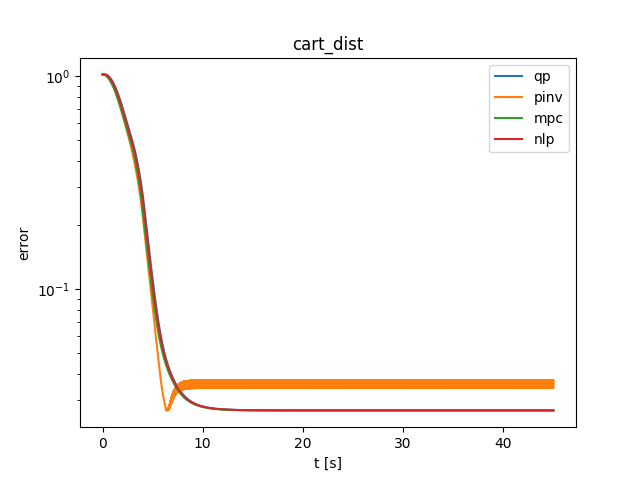

Text(0.5,1,'cart_dist')

In [16]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["cart_dist_res"]["t_sim"],
            controllers[name]["cart_dist_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("cart_dist")

<IPython.core.display.Javascript object>


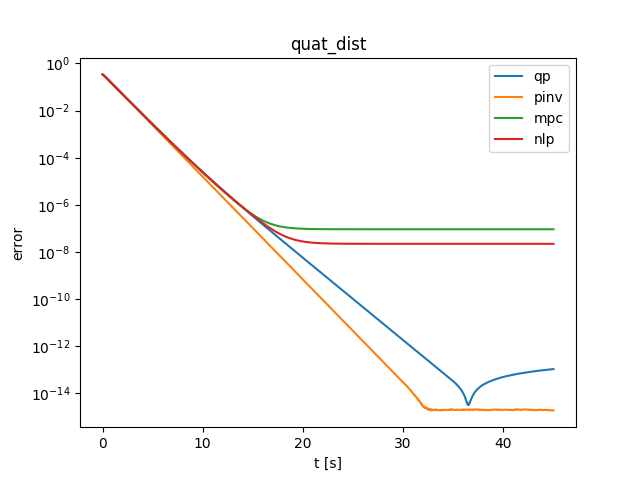

Text(0.5,1,'quat_dist')

In [17]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["quat_dist_res"]["t_sim"],
            controllers[name]["quat_dist_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("quat_dist")

## Look at frame in 3D

<IPython.core.display.Javascript object>


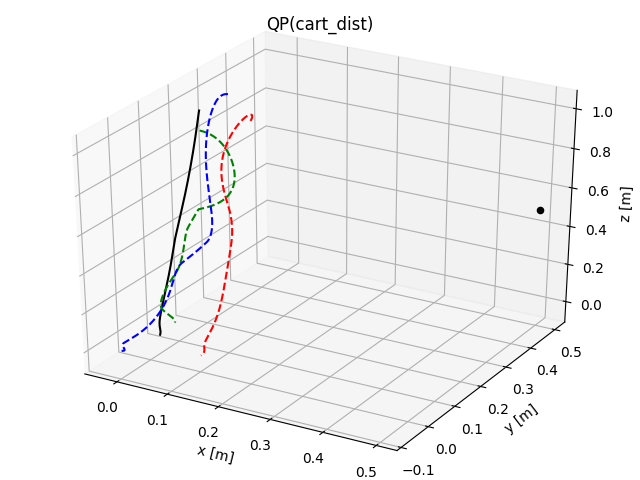

Text(0.5,0.92,'QP(cart_dist)')

In [18]:
ax = common_plots.frame_3d(controllers["qp"]["cart_dist_res"],p_des=p_des)
ax.set_title("QP(cart_dist)")

<IPython.core.display.Javascript object>


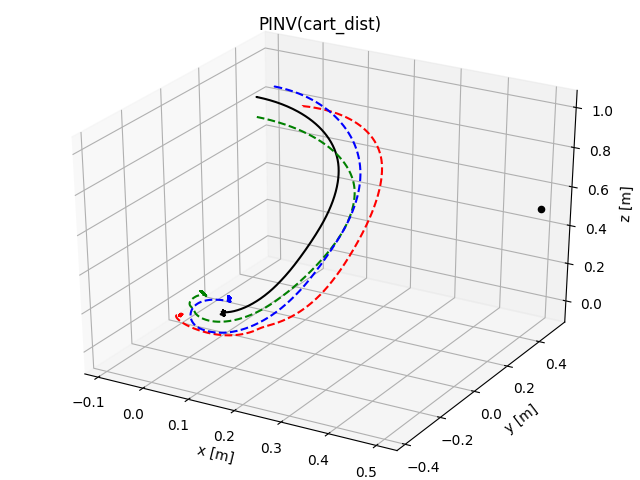

Text(0.5,0.92,'PINV(cart_dist)')

In [19]:
ax = common_plots.frame_3d(controllers["pinv"]["cart_dist_res"], p_des=p_des)
ax.set_title("PINV(cart_dist)")

<IPython.core.display.Javascript object>


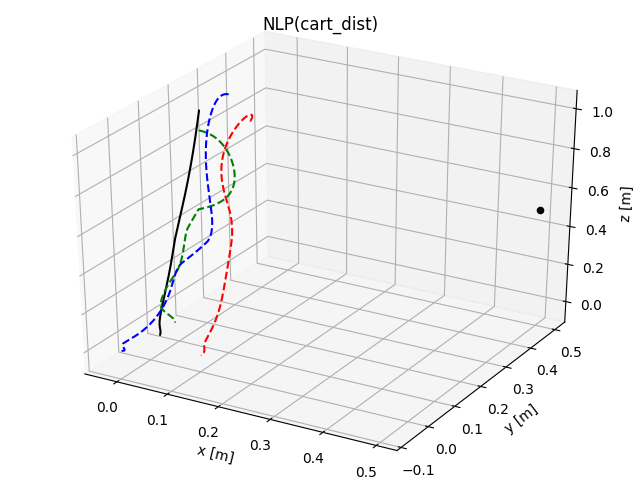

Text(0.5,0.92,'NLP(cart_dist)')

In [20]:
ax = common_plots.frame_3d(controllers["nlp"]["cart_dist_res"], p_des=p_des)
ax.set_title("NLP(cart_dist)")

<IPython.core.display.Javascript object>


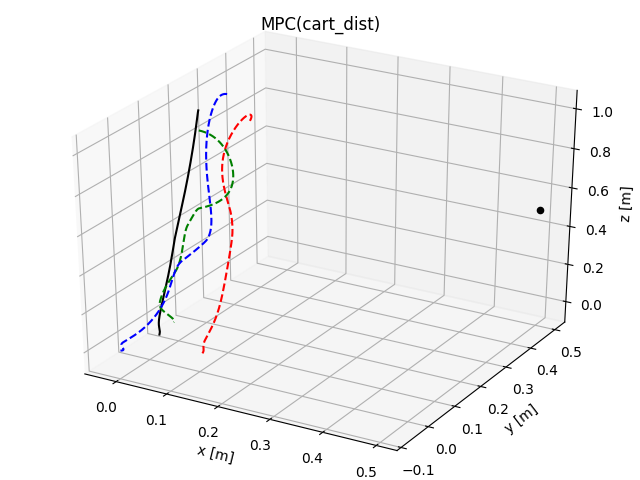

Text(0.5,0.92,'MPC(cart_dist)')

In [21]:
ax = common_plots.frame_3d(controllers["mpc"]["cart_dist_res"], p_des=p_des)
ax.set_title("MPC(cart_dist)")

<IPython.core.display.Javascript object>


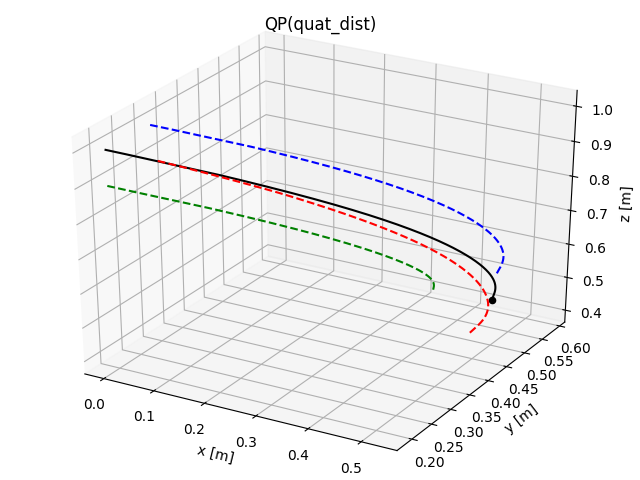

Text(0.5,0.92,'QP(quat_dist)')

In [22]:
ax = common_plots.frame_3d(controllers["qp"]["quat_dist_res"], p_des=p_des)
ax.set_title("QP(quat_dist)")

<IPython.core.display.Javascript object>


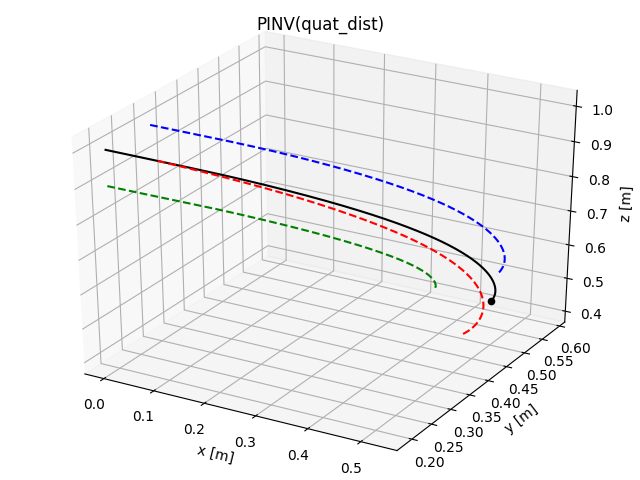

Text(0.5,0.92,'PINV(quat_dist)')

In [23]:
ax = common_plots.frame_3d(controllers["pinv"]["quat_dist_res"], p_des=p_des)
ax.set_title("PINV(quat_dist)")

<IPython.core.display.Javascript object>


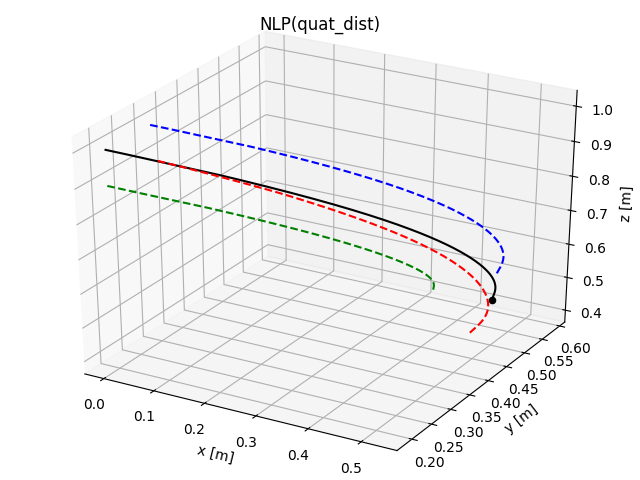

Text(0.5,0.92,'NLP(quat_dist)')

In [24]:
ax = common_plots.frame_3d(controllers["nlp"]["quat_dist_res"], p_des=p_des)
ax.set_title("NLP(quat_dist)")

<IPython.core.display.Javascript object>


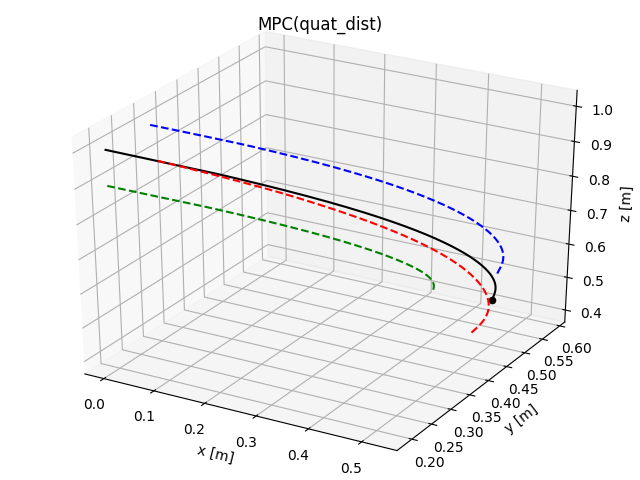

Text(0.5,0.92,'MPC(quat_dist)')

In [25]:
ax = common_plots.frame_3d(controllers["mpc"]["quat_dist_res"], p_des=p_des)
ax.set_title("MPC(quat_dist)")

What have we found out? Well, the proper `quat_dist` from our theory doesn't seem to work. But the "difference" system seems to work. Both in Cartesian space and Quaternion. We also see that the different approaches have different 

## Moving to a frame

In this example the frame attached to the end-effector is to match a reference frame. We test two approaches to matching a frame with dual quaternions:

1. Naive matching of the dual quaternion
2. Matching of rotation and position separately

We'll grab the `joint_speed_limits_cnstr` and `joint_limit_cnstr` from before.

In [59]:
rpy = [
    0.0,
    0.0,
    0.0
]
xyz = [
    0.2,
    0.2,
    0.75
]
Q_des = numpy_geom.dual_quaternion_revolute(xyz, rpy, # cartesian and euler angles
                                            [1,0,0],0.0) # If we wanted an extra axis-angle rotation afterwards
Q_id = numpy_geom.dual_quaternion_revolute([0.,0.,0.],[0.,0.,0.],[1.,0.,0.],0.0)
T_des = numpy_geom.T_rpy(xyz,*rpy)
print("Desired frame in quaternion: "+str(Q_des))
print("Identity quaternion: "+str(Q_id))

Desired frame in quaternion: [ 0.     0.     0.     1.     0.1    0.1    0.375  0.   ]
Identity quaternion: [ 0.  0.  0.  1.  0.  0.  0.  0.]


In [60]:
Q_dist1 = dual_quaternion_product(Q_fk(q),dual_quaternion_conj(Q_des)) - Q_id
Q_dist1_cnstr = cc.EqualityConstraint(
    label="Q_dist1_cnstr",
    expression=Q_dist1,
    constraint_type="soft",
    gain = 1.0
)
Q_dist1_cnstr.eval = cs.Function("Q_dist1",[t,q],[cs.norm_2(Q_dist1)])


Q_dist2 = dual_quaternion_product(dual_quaternion_conj(Q_des - Q_fk(q)), Q_des)
Q_dist2_cnstr = cc.EqualityConstraint(
    label="Q_dist2_cnstr",
    expression=Q_dist2,
    constraint_type="soft",
    gain=1.0
)
Q_dist2_cnstr.eval = cs.Function("Q_dist2",[t,q],[cs.norm_2(Q_dist2)])

In [61]:
# Let's test all the controllers
controller_classes = {
    "qp":cc.ReactiveQPController, 
    "nlp":cc.ReactiveNLPController, 
    "pinv":cc.PseudoInverseController, 
    "mpc":cc.ModelPredictiveController
}
controllers = {"qp":{},"nlp":{},"pinv":{},"mpc":{}}

In [62]:
cnstr_situations={"Q_dist1":Q_dist1_cnstr, "Q_dist2":Q_dist2_cnstr}

In [63]:
# Setup all Q_dist1_cnstr controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [Q_dist1_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [Q_dist1_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="Q_dist1",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["Q_dist1"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["Q_dist1"].setup_problem_functions()
    controllers[key]["Q_dist1"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [64]:
# Setup all Q_dist2_cnstr controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [Q_dist2_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [Q_dist2_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="Q_dist2",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["Q_dist2"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["Q_dist2"].setup_problem_functions()
    controllers[key]["Q_dist2"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [65]:
dt = 0.01
timesteps = 4500
# Run all the simulations:
for cntr_key in controllers.keys():
    print("Controller:"+cntr_key)
    for cnstr_key in cnstr_situations.keys():
        print("\tCNSTR:"+str(cnstr_key))
        print("\t\tSetting up initial value problem")
        controllers[cntr_key][cnstr_key].setup_initial_problem_solver()
        print("\t\tSolving initial value problem")
        slack_res = controllers[cntr_key][cnstr_key].solve_initial_problem(0,UR5_home)[-1]
        print("\t\tSimulating:"+cnstr_key)
        # Simulate it!
        t_sim = cs.np.array([dt*i for i in xrange(timesteps+1)])
        # Robot
        q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
        q_sim[0,:] = UR5_home
        dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
        # Cartesian position
        p_sim = cs.np.zeros((len(t_sim), 3))
        p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
        # Rotation
        R_sim = cs.np.zeros((len(t_sim), 3, 3))
        R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
        # Error in constraint
        e_sim = cs.np.zeros(len(t_sim))
        e_sim[0] = cnstr_situations[cnstr_key].eval(t_sim[0],q_sim[0,:])
        # Loop
        #try:
        for i in range(len(t_sim) - 1):
            res = controllers[cntr_key][cnstr_key].solve(t_sim[i],q_sim[i,:],warmstart_slack_var=slack_res)
            dq_sim[i,:] = res[0].toarray()[:,0]
            if res[-1] is not None:
                slack_res = res[-1].toarray()[:,0]
            for idx, dqi in enumerate(dq_sim[i,:]):
                dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
            q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
            p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
            R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()
            e_sim[i+1] = cnstr_situations[cnstr_key].eval(t_sim[i],q_sim[i+1,:])
        #except:
            #print("\tFAILED")
        controllers[cntr_key][str(cnstr_key)+"_res"] = {
            "t_sim":t_sim,
            "dq_sim": dq_sim,
            "q_sim": q_sim,
            "p_sim": p_sim,
            "R_sim": R_sim,
            "e_sim": e_sim
        }

Controller:qp
	CNSTR:Q_dist2
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist2
	CNSTR:Q_dist1
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist1
Controller:pinv
	CNSTR:Q_dist2
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist2
	CNSTR:Q_dist1
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist1
Controller:mpc
	CNSTR:Q_dist2
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist2
	CNSTR:Q_dist1
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist1
Controller:nlp
	CNSTR:Q_dist2
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist2
	CNSTR:Q_dist1
		Setting up initial value problem
		Solving initial value problem
		Simulating:Q_dist1


## Inspecting the errors

<IPython.core.display.Javascript object>


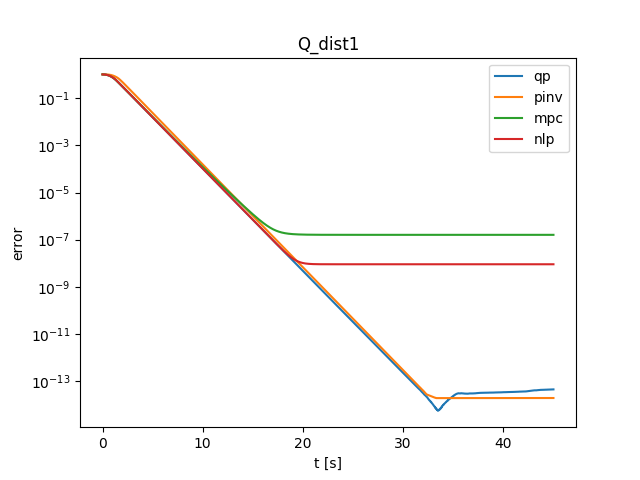

Text(0.5,1,'Q_dist1')

In [66]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["Q_dist1_res"]["t_sim"],
            controllers[name]["Q_dist1_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("Q_dist1")

<IPython.core.display.Javascript object>


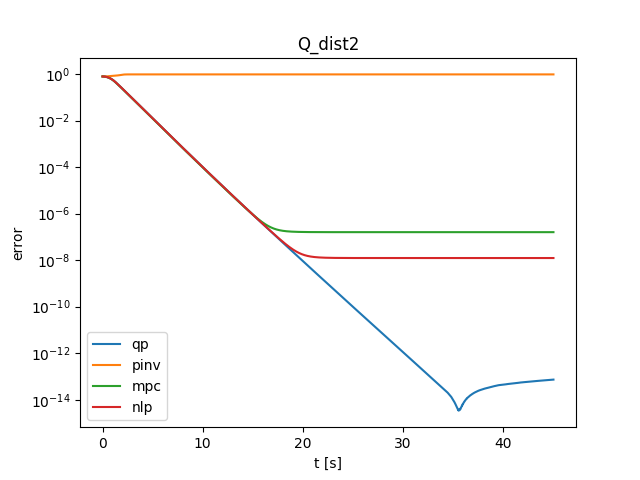

Text(0.5,1,'Q_dist2')

In [67]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["Q_dist2_res"]["t_sim"],
            controllers[name]["Q_dist2_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("Q_dist2")

## Look at frame in 3D

<IPython.core.display.Javascript object>


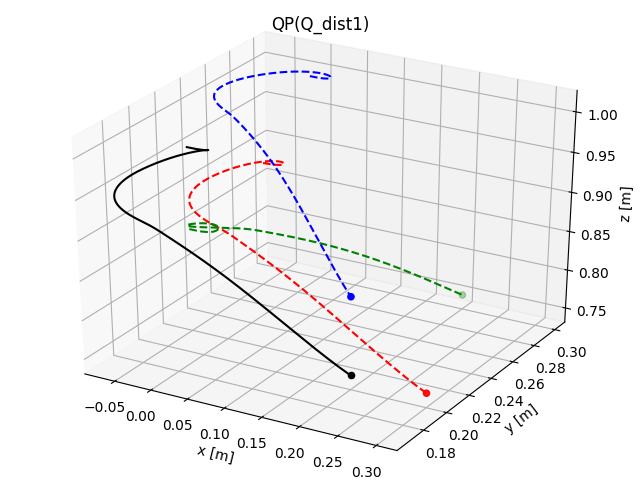

Text(0.5,0.92,'QP(Q_dist1)')

In [68]:
ax = common_plots.frame_3d(controllers["qp"]["Q_dist1_res"],T_des=T_des)
ax.set_title("QP(Q_dist1)")

<IPython.core.display.Javascript object>


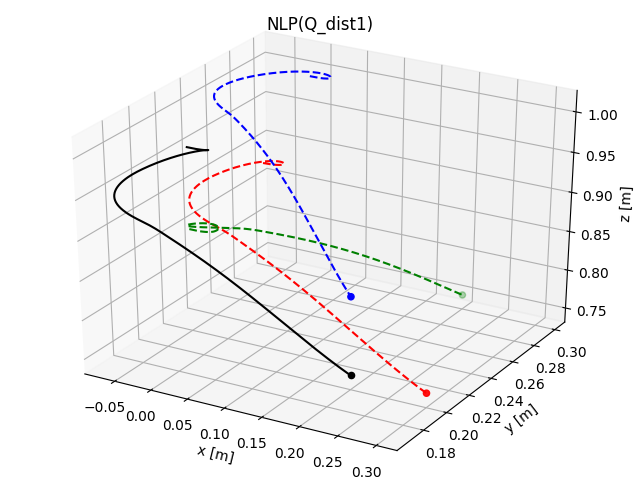

Text(0.5,0.92,'NLP(Q_dist1)')

In [69]:
ax = common_plots.frame_3d(controllers["nlp"]["Q_dist1_res"],T_des=T_des)
ax.set_title("NLP(Q_dist1)")

<IPython.core.display.Javascript object>


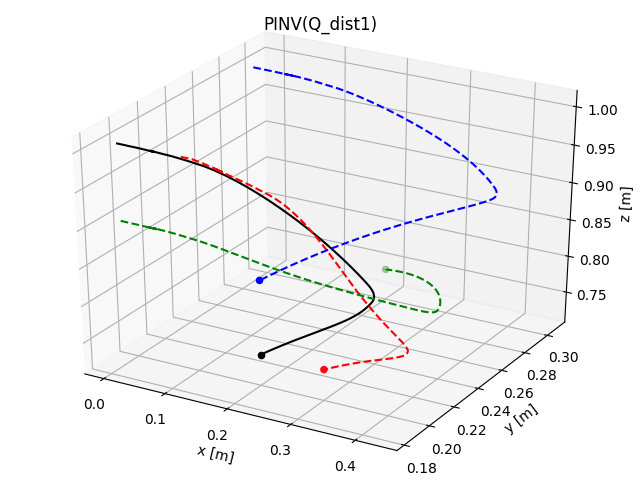

Text(0.5,0.92,'PINV(Q_dist1)')

In [70]:
ax = common_plots.frame_3d(controllers["pinv"]["Q_dist1_res"],T_des=T_des)
ax.set_title("PINV(Q_dist1)")

<IPython.core.display.Javascript object>


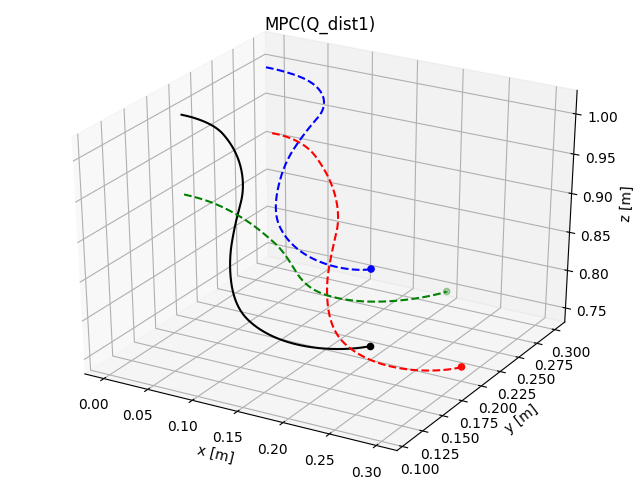

Text(0.5,0.92,'MPC(Q_dist1)')

In [71]:
ax = common_plots.frame_3d(controllers["mpc"]["Q_dist1_res"],T_des=T_des)
ax.set_title("MPC(Q_dist1)")

<IPython.core.display.Javascript object>


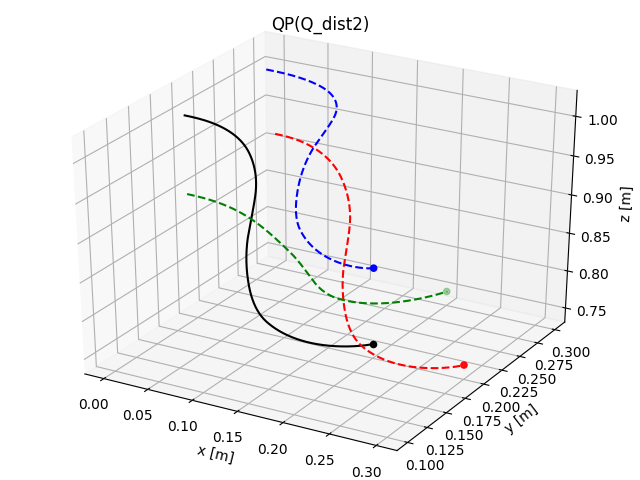

Text(0.5,0.92,'QP(Q_dist2)')

In [72]:
ax = common_plots.frame_3d(controllers["qp"]["Q_dist2_res"],T_des=T_des)
ax.set_title("QP(Q_dist2)")

<IPython.core.display.Javascript object>


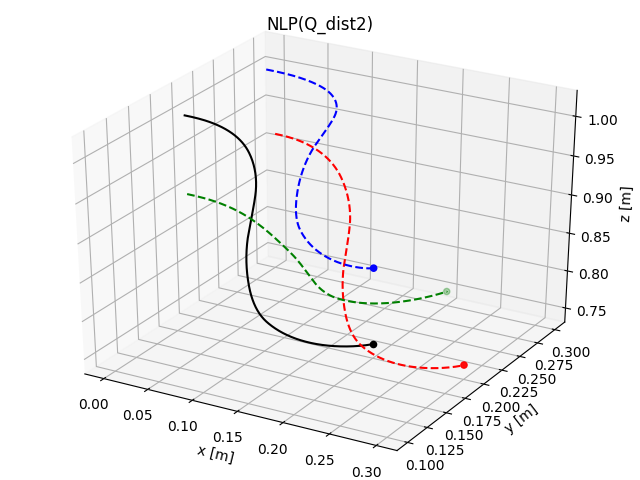

Text(0.5,0.92,'NLP(Q_dist2)')

In [73]:
ax = common_plots.frame_3d(controllers["nlp"]["Q_dist2_res"],T_des=T_des)
ax.set_title("NLP(Q_dist2)")

<IPython.core.display.Javascript object>


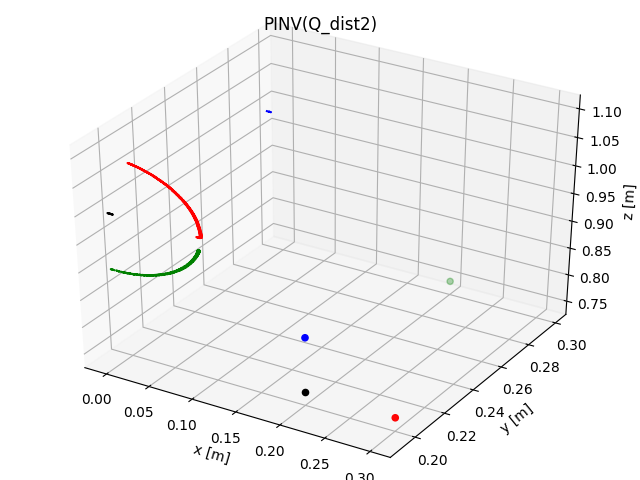

Text(0.5,0.92,'PINV(Q_dist2)')

In [74]:
ax = common_plots.frame_3d(controllers["pinv"]["Q_dist2_res"],T_des=T_des)
ax.set_title("PINV(Q_dist2)")

<IPython.core.display.Javascript object>


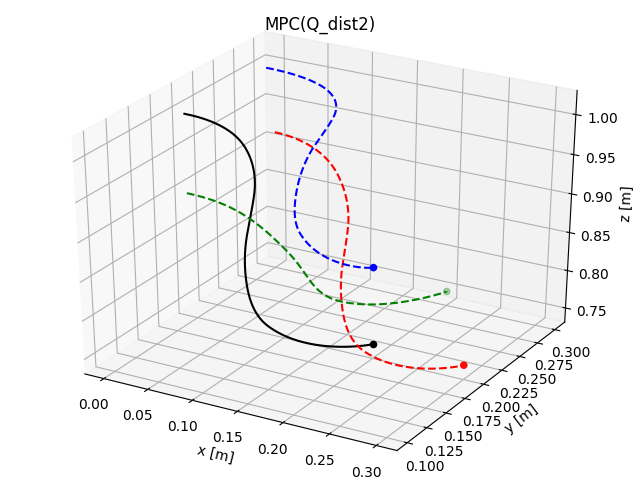

Text(0.5,0.92,'MPC(Q_dist2)')

In [75]:
ax = common_plots.frame_3d(controllers["mpc"]["Q_dist2_res"],T_des=T_des)
ax.set_title("MPC(Q_dist2)")

## Conclusion
We can use dual quaternions to move to a desired frame. The optimization-based approaches are more robust to the method by which we define our positioning constraint, and we're not guaranteed that the pseudo-inverse will handle it in all cases. Perhaps we can try different desired poses, initial positions, and pseudoinverse parameters (e.g. jacobian damping) and see if we figure out when it fails?